### Load data ###

In [43]:
import pickle

with open('NBA_temporal_dataset.pkl', 'rb') as file:
    temporal_data_dict = pickle.load(file)

X_primary = temporal_data_dict['X_primary']
X_opposing = temporal_data_dict['X_opposing'] 
y = temporal_data_dict['y']

print(X_primary.shape)
print(X_opposing.shape)
print(y.shape)

(83178, 5, 42)
(83178, 5, 42)
(83178, 1)


### Reshape data so that each sample is 2D array ###

In [44]:
import numpy as np

X_primary = X_primary.reshape(X_primary.shape[0], -1)
X_opposing = X_opposing.reshape(X_opposing.shape[0], -1)

X = np.concatenate((X_primary, X_opposing), axis=1)
print(X.shape)
print(y.shape)

(83178, 420)
(83178, 1)


### Split data ###

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (62383, 420)
X_test shape:  (20795, 420)
y_train shape:  (62383, 1)
y_test shape:  (20795, 1)


## Logistic Regression ##

In [46]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.01, 0.1, 1 ],
    'penalty': ['l2', 'l1'],
    'solver': ['saga'],
    }

gsCV = GridSearchCV(LogisticRegression(), param_grid, cv=StratifiedKFold(10, shuffle=True, random_state=42), n_jobs=-1)

gsCV.fit(X_train, y_train)


c:\Users\Alex1\.conda\envs\cs5100\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Alex1\.conda\envs\cs5100\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2', 'l1'],
                         'solver': ['saga']})

In [47]:
y_pred = gsCV.predict(X_test)
y_pred_training = gsCV.predict(X_train)

from sklearn.metrics import accuracy_score, confusion_matrix
print("Best Parameters:", gsCV.best_params_)
print(F"Best CV Score: {gsCV.best_score_*100}%")
print(f"Train Accuracy: {(accuracy_score(y_train, y_pred_training) * 100)}%")
print(f"Test Accuracy: {(accuracy_score(y_test, y_pred) * 100)}%")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
Best CV Score: 61.778053388070084%
Train Accuracy: 62.46573585752528%
Test Accuracy: 61.519596056744405%
Confusion Matrix:
 [[6433 4018]
 [3984 6360]]


## Gaussian Naive Bayes ##

In [48]:
from sklearn.naive_bayes import GaussianNB

param_grid = {'var_smoothing': [1e-6, 1e-5]}

gsCV_gnb = GridSearchCV(GaussianNB(), param_grid, cv=StratifiedKFold(10, shuffle=True, random_state=42), n_jobs=-1)

gsCV_gnb.fit(X_train, y_train)

c:\Users\Alex1\.conda\envs\cs5100\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-06, 1e-05]})

In [49]:
y_pred_gNB = gsCV_gnb.predict(X_test)
y_pred_gNB_training = gsCV_gnb.predict(X_train)

print("Best Parameters:", gsCV_gnb.best_params_)
print(F"Best CV Score: {gsCV_gnb.best_score_*100}%")
print(f"Train Accuracy: {(accuracy_score(y_train, y_pred_gNB_training) * 100)}%")
print(f"Accuracy: {(accuracy_score(y_test, y_pred_gNB) * 100)}%")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gNB))


Best Parameters: {'var_smoothing': 1e-05}
Best CV Score: 59.82721600276185%
Train Accuracy: 60.47160284051745%
Accuracy: 60.283722048569366%
Confusion Matrix:
 [[5309 5142]
 [3117 7227]]


### Time model ###

In [50]:
### Logistic Regression

import time

start_time = time.time()
y_pred = gsCV.predict(X_test)
inference_time = time.time() - start_time
print(f"Inference time for {len(X_test)} samples: {inference_time:.10f} seconds")
print(f"Avg per sample: {inference_time / len(X_test):.10f} sec")

Inference time for 20795 samples: 0.0180029869 seconds
Avg per sample: 0.0000008657 sec


In [51]:
### Gaussian Naive Bayes

import time

start_time = time.time()
y_pred = gsCV.predict(X_test)
inference_time = time.time() - start_time
print(f"Inference time for {len(X_test)} samples: {inference_time:.10f} seconds")
print(f"Avg per sample: {inference_time / len(X_test):.10f} sec")

Inference time for 20795 samples: 0.0190007687 seconds
Avg per sample: 0.0000009137 sec


### Evaluating model ###

In [52]:
# FUnction to evaulate the model

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_classifier(model, X_test, y_test, model_name="Model"):
    # Predict class and probabilities
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probability of class 1
    
    # Scores
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)

    # Print metrics
    print(f"\nEvaluation for {model_name}")
    print(f"Accuracy     : {acc:.4f}")
    print(f"Precision    : {prec:.4f}")
    print(f"Recall       : {rec:.4f}")
    print(f"F1 Score     : {f1:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


Evaluation for Logistic Regression
Accuracy     : 0.6152
Precision    : 0.6128
Recall       : 0.6148
F1 Score     : 0.6138
ROC-AUC Score: 0.6608

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.62      0.62     10451
           1       0.61      0.61      0.61     10344

    accuracy                           0.62     20795
   macro avg       0.62      0.62      0.62     20795
weighted avg       0.62      0.62      0.62     20795



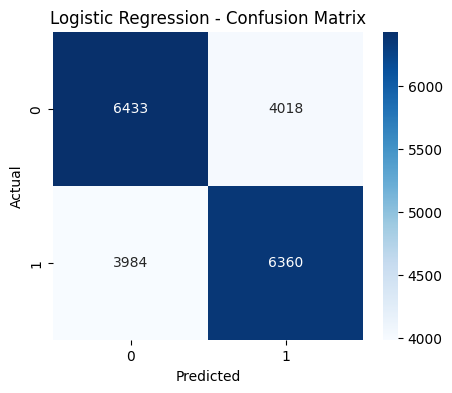

In [53]:
# Evaluating Logistic Regression model
evaluate_classifier(gsCV, X_test, y_test, model_name="Logistic Regression")


Evaluation for Gaussian Naive Bayes
Accuracy     : 0.6028
Precision    : 0.5843
Recall       : 0.6987
F1 Score     : 0.6364
ROC-AUC Score: 0.6460

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.51      0.56     10451
           1       0.58      0.70      0.64     10344

    accuracy                           0.60     20795
   macro avg       0.61      0.60      0.60     20795
weighted avg       0.61      0.60      0.60     20795



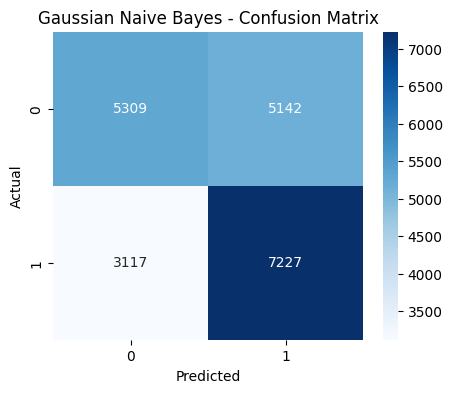

In [54]:
# Evaluating Gaussian Naive Bayes model
evaluate_classifier(gsCV_gnb, X_test, y_test, model_name="Gaussian Naive Bayes")

In [55]:
# Function to plot prediction distribution
import matplotlib.pyplot as plt
import seaborn as sns

def plot_prediction_distribution(model, X_test, y_test, model_name="Model"):
    y_proba = model.predict_proba(X_test)[:, 1]  # probability of class 1 (home win)
    
    plt.figure(figsize=(8, 5))
    sns.histplot(y_proba[y_test == 1], color="green", label="True Wins", kde=True, stat="density", bins=30)
    sns.histplot(y_proba[y_test == 0], color="red", label="True Losses", kde=True, stat="density", bins=30)
    
    plt.title(f"{model_name} – Probability Distribution of Predicted Wins")
    plt.xlabel("Predicted Probability of Win")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()


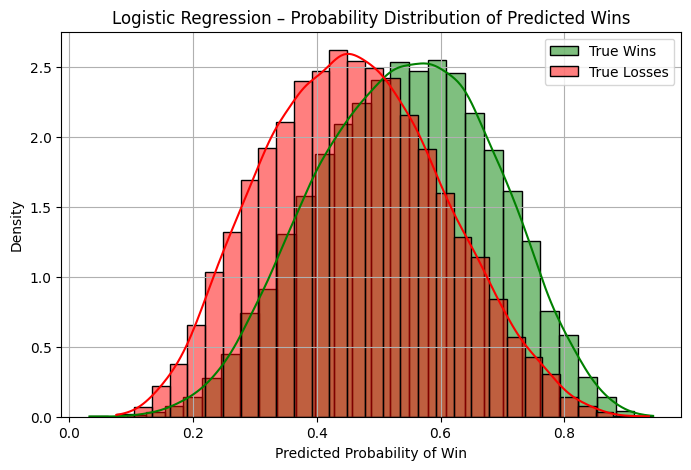

In [56]:
plot_prediction_distribution(gsCV, X_test, y_test.ravel(), model_name="Logistic Regression")


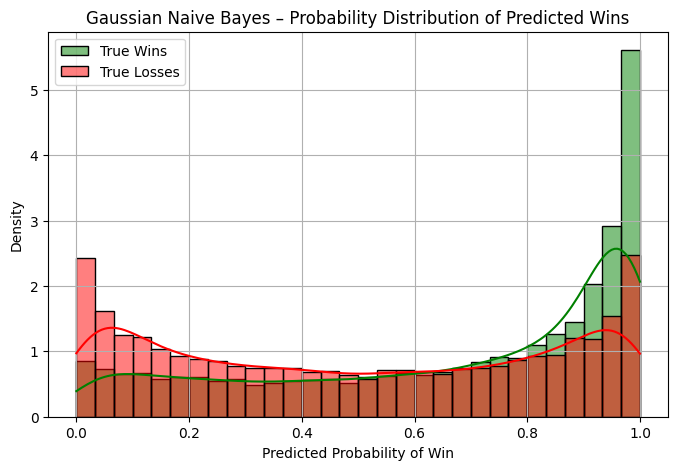

In [57]:
plot_prediction_distribution(gsCV_gnb, X_test, y_test.ravel(), model_name="Gaussian Naive Bayes")

In [58]:
# Function for ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(model, X_test, y_test, model_name="Model"):
    # Get predicted probabilities for the positive class (class = 1)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Compute false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve – {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


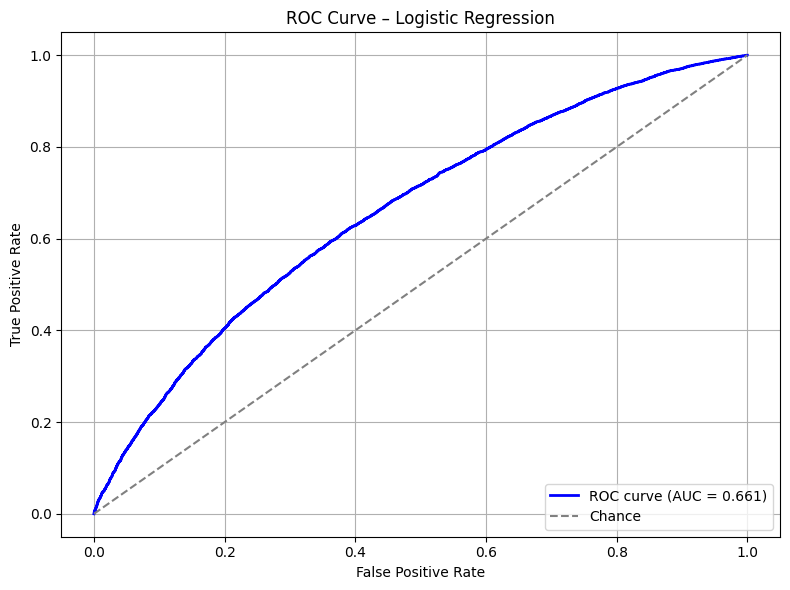

In [59]:
plot_roc_curve(gsCV, X_test, y_test, model_name="Logistic Regression")


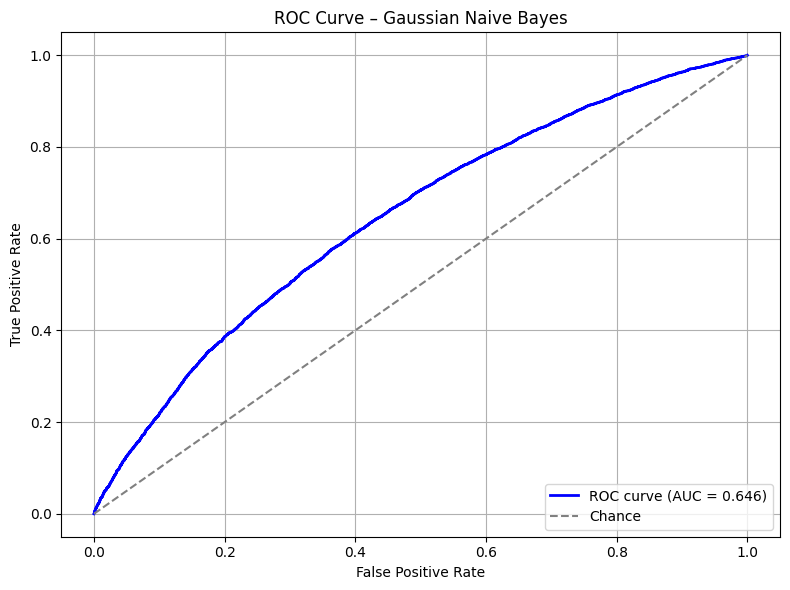

In [60]:
plot_roc_curve(gsCV_gnb, X_test, y_test, model_name="Gaussian Naive Bayes")

### Save models ###

In [61]:
import pickle
import os

# Define the relative model path using os.path.join()
model_path = os.path.join('.', 'models')

with open(os.path.join(model_path, "logistic_regression.pkl"), "wb") as f:
    pickle.dump(gsCV, f)

with open(os.path.join(model_path, "gaussian_naive_bayes.pkl"), "wb") as f:
    pickle.dump(gsCV_gnb, f)